### Two Body Simulation

A worksheet to simulate two spiraling black holes, using Post-Minkowski corrections to accounts for effects of relativity.

In [4]:
using Pkg
using DifferentialEquations
using Plots

#This is a homemade package containing the differential equations used to calculate the Hamiltonian numerically.
Pkg.activate("HamiltonianFunctions")
using HamiltonianFunctions

@userplot TwoBodyPlot
@recipe function f(tb::TwoBodyPlot)
    m, x, y, xarray, yarray, negx, posx, negy, posy = tb.args
    n = 100
    xlims --> (negx, posx)
    ylims --> (negy, posy)
    append!(xarray, x)
    append!(yarray, y)
    if size(xarray)[1] > n
        deleteat!(xarray, 1)
        deleteat!(yarray, 1)
    end
    linewidth --> range(0, m * 10, length = n)
    #seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    xarray, yarray
end

 Activating environment at `~/Research/Post-Minkowski/notebooks/HamiltonianFunctions/Project.toml`


In [5]:
## This cell is for setting the parameters of the code

m1 = 12; # Mass of the first body in solar masses
m2 = 10; # Mass of the second body
D = 1000; # Initial separation of the bodies, in kilometers
ecc = 0.0; # eccentricity of the orbits
G = 1; # Gravitational constant
relativity = true; # A boolean value; if true, the code will apply Post-Minkowski relativistic corrections.
tspan = (0.0, 34500.0 * 1); # The amount of time for which the simulation runs

GSI = 6.647e-11;
MSUN = 1.989e30;
KM = 1000;

M = MSUN;
L = KM;
T = sqrt(L^3 / (GSI * M));

pUnits = M * L / T
KEUnits = pUnits * L / T;

In [6]:
## Calculates factors based on eccentricity

if !(0 <= ecc <= 1)
    ecc = 0.0
end
qfac = 1 - ecc;
pfac = sqrt((1 + ecc)/(1 - ecc));

## Calculates inital position and momentum

mu = m1 * m2 / (m1 + m2)
p_theta = sqrt(G * m1 * m2 * mu * D )

x2 = D / (1 + (m1 / m2));
x1 = x2 - D;
py2 = p_theta / D;
py1 = -py2;

#Set up initial arrays for ODE problem

c0 = [m1, m2, G]
q01 = [x1 * qfac, 0.0]
p01 = [0.0, py1 * pfac]
q02 = [x2 * qfac, 0.0]
p02 = [0.0, py2 * pfac]
u0 = collect(Base.Iterators.flatten([q01, p01, q02, p02]));

pi1, pi2 = sqrt((p01[1]^2) + (p01[2]^2)), sqrt((p02[1]^2) + (p02[2]^2));
KEi1, KEi2 = pi1^2 / (2 * m1), pi2^2 / (2 * m2);
initialKE1, initialKE2 = KEi1 * KEUnits, KEi2 * KEUnits

#Create and solve ODE problem, finding ending data

if relativity
    prob = ODEProblem(HamiltonianFunctions.PM, u0, tspan, c0)
else
    prob = ODEProblem(HamiltonianFunctions.Hamiltonian, u0, tspan, c0)
end

sol = solve(prob, RK4(), adaptive = true, reltol = 1.0e-8, abstol = 1.0e-8, saveat = 100);

ss1 = sol[1,:]
ss2 = sol[2,:]
ss3 = sol[5,:]
ss4 = sol[6,:];

len = size(sol[1,:])[1]

pf1, pf2 = sqrt((sol[3,:][len]^2) + (sol[4,:][len]^2)), sqrt((sol[7,:][len]^2) + (sol[8,:][len]^2));
KEf1, KEf2 = pf1^2 / (2 * m1), pf2^2 / (2 * m2);
finalKE1, finalKE2 = KEf1 * KEUnits, KEf2 * KEUnits 
dKE1, dKE2 = finalKE1 - initialKE1, finalKE2 - initialKE2
xf, yf = ss1[len] - ss3[len], ss2[len] - ss4[len]
Df = sqrt(xf^2 + yf^2)
println(dKE1)
println(dKE2)
println(Df)

5.029225684582267e44
6.0350708214987e44
969.6570832534419


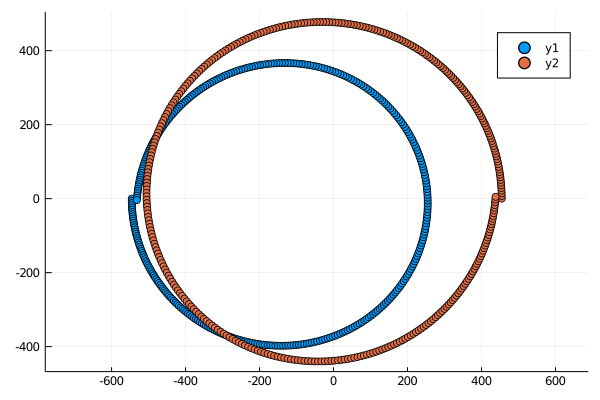

In [7]:
scatter(ss1, ss2, aspect_ratio = :equal);
plt = scatter!(ss3, ss4, aspect_ratio = :equal)

┌ Info: Saved animation to 
│   fn = /Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif
└ @ Plots /Users/zackarywindham/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/Users/zackarywindham/Research/Post-Minkowski/notebooks/tmp.gif")
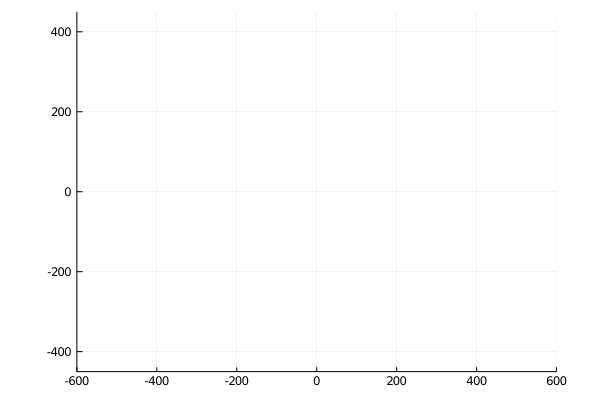

In [8]:
xarr1, yarr1, xarr2, yarr2 = [], [], [], []
xneg, xpos, yneg, ypos = -600, 600, -450, 450

r = m1 / m2
m10 = r / (1 + r)
m20 = 1 - m10

anim = @gif for i = 1:size(ss1)[1]
    twobodyplot(m10, ss1[i], ss2[i], xarr1, yarr1, xneg, xpos, yneg, ypos)
    twobodyplot!(m20, ss3[i], ss4[i], xarr2, yarr2, xneg, xpos, yneg, ypos)
    end every 5